In [1]:
import pandas as pd
import os
import numpy as np
import datetime
#import duckdb
from plotnine import *
pd.set_option("display.max_rows", 20)

In [2]:
filename = os.getcwd() + "/train.csv"
data = pd.read_csv(filename)

In [3]:
data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
target = 'Survived'
numeric_cols = ['Age', 'SibSp', 'Parch', 'Fare']
categorical_cols = ['Pclass', 'Sex', 'Embarked']

In [5]:
from sklearn import metrics

def model_diagnostics(y_test, preds, preds_binary):
    dict_scores = {}

    dict_scores['accuracy'] = metrics.accuracy_score(y_test, preds_binary)
    dict_scores['average_precision'] = metrics.average_precision_score(y_true = y_test, y_score = preds)
    dict_scores['f1_score'] = metrics.f1_score(y_test, preds_binary)

    dict_scores

    # Confusion matrix
    cm = metrics.confusion_matrix(y_test, preds_binary)
    cm_display = metrics.ConfusionMatrixDisplay(cm)

    # Precision recall curve
    x = metrics.precision_recall_curve(y_test, preds)

    df_pr_curve = pd.DataFrame()

    df_pr_curve['precision'] = x[0][:-1]
    df_pr_curve['recall'] = x[1][:-1]
    df_pr_curve['threshold'] = x[2]

    auprc = metrics.auc(df_pr_curve['recall'], df_pr_curve['precision'])
    auprc_noskill = np.mean(y_test)
    auprc_text = f"Area under PR curve: {round(auprc, 3)}"

    pr_plot = (
        ggplot(df_pr_curve, aes(x = 'recall', y = 'precision')) 
        + geom_line(size = 1, color = 'orange')
        + geom_hline(aes(yintercept = auprc_noskill), linetype = 'dashed')
        + ggtitle("Precision Recall Curve")
        + geom_label(label = auprc_text, x = np.min(df_pr_curve['recall']), y = np.min(df_pr_curve['precision']), ha = 'left', va = 'bottom', size = 10)
    )

    # Receiver operating characteristic curve
    x = metrics.roc_curve(y_test, preds)
    df_roc_curve = pd.DataFrame()

    df_roc_curve['fpr'] = x[0]
    df_roc_curve['tpr'] = x[1]
    df_roc_curve['threshold'] = x[2]

    auroc = metrics.auc(df_roc_curve['fpr'], df_roc_curve['tpr'])
    auroc_text = f"Area under ROC curve: {round(auroc, 4)}"

    roc_plot = (
        ggplot(df_roc_curve, aes(x = 'fpr', y = 'tpr')) 
        + geom_line(size = 1, color = 'orange')
        + geom_abline(intercept = 0, slope = 1, linetype = 'dashed')
        + xlab("False Positive Rate")
        + ylab("True Positive Rate")
        + ggtitle("Receiver Operating Characteristic Curve")
        + geom_label(label = auroc_text, x = np.max(df_roc_curve['fpr']), y = np.min(df_roc_curve['tpr']), ha = 'right', va = 'bottom', size = 10)
    )

    #ECDF/density plot of predictions
    preds_df = pd.DataFrame(np.vstack([preds, y_test]).T)
    preds_df.columns = ['pred', 'label']

    preds_ecdf_plot = (
        ggplot(preds_df, aes(x = 'pred'))
        + stat_ecdf()
        + ggtitle("Emperical CDF of predictions")
    )

    preds_density_plot = (
        ggplot(preds_df, aes(x = 'pred'))
        + geom_density()
        + ggtitle("Density plot of predictions")
    )

    #Get everything ready to return
    ret_list_scores = [dict_scores, df_pr_curve, df_roc_curve]
    ret_list_plots = [pr_plot, roc_plot, preds_ecdf_plot, preds_density_plot]

    return((ret_list_scores, cm_display, ret_list_plots))

# Bin continuous features, make survival plots based on quantiles

In [6]:
def summarise_continuous_feature(df_input, column, outcome, n_quantiles = 10):
    
    group_assignments, bins = pd.qcut(df_input[column], q = n_quantiles, retbins = True)
    df_input['quantile'] = group_assignments
    #old line of code cutting data into quantiles
    #pd.cut(df['Age'], bins, labels = np.arange(10))  

    df_mean_outcome = (
        df_input
        .groupby('quantile')
        .agg(
            n = ('quantile', 'count'),
            avg_outcome = (outcome, 'mean')
        )
        .reset_index()
        .round(2)
    )

    df_outcome_counts = (
        df_input
        .astype({outcome: 'string'})
        .groupby(['quantile', outcome])
        .agg(n = (outcome, 'count'))
        .reset_index()
    )

    plot_histogram = (
        ggplot(df_input, aes(x = column))
        + geom_histogram(color = 'orange', fill = 'orange')
    )

    plot_mean_outcome = (
        ggplot(df_mean_outcome, aes(x = 'quantile', y = 'avg_outcome'))
        + geom_bar(stat = 'identity', color = 'green', fill = 'green')
        + xlab(f'Quantile of {column}')
        + ylab(f'Average of {outcome}')
        + theme(axis_text_x=element_text(rotation=-45, hjust=0))
    )

    plot_outcome_counts = (
        ggplot(df_outcome_counts, aes(x = 'quantile', y = 'n', color = outcome, fill = outcome))
        + geom_bar(stat = 'identity', position = 'dodge')
        + xlab(f'Quantile of {column}')
        + theme(axis_text_x=element_text(rotation=-45, hjust=0))
    )

    ret_dict = {
        'mean_outcome_by_quantile': df_mean_outcome,
        'outcome_count_by_quantile': df_outcome_counts,
        'histogram': plot_histogram,
        'plot_mean_outcome_by_quantile': plot_mean_outcome,
        'plot_outcome_counts': plot_outcome_counts,
    }

    return(ret_dict)

#summarise_continuous_feature(df_input = data, column = 'Age', outcome = 'Survived', n_quantiles = 10)

mean_outcome_by_quantile
        quantile   n  avg_outcome
0   (0.419, 7.0]  50         0.68
1    (7.0, 16.0]  50         0.42
2   (16.0, 19.0]  64         0.38
3   (19.0, 21.0]  40         0.20
4   (21.0, 23.0]  42         0.38
5   (23.0, 25.0]  55         0.38
6   (25.0, 27.0]  36         0.47
7   (27.0, 29.0]  47         0.32
8   (29.0, 31.8]  44         0.41
9   (31.8, 34.0]  50         0.44
10  (34.0, 37.0]  48         0.48
11  (37.0, 41.0]  46         0.39
12  (41.0, 47.0]  53         0.30
13  (47.0, 54.0]  47         0.51
14  (54.0, 80.0]  42         0.31
outcome_count_by_quantile
        quantile Survived   n
0   (0.419, 7.0]        0  16
1   (0.419, 7.0]        1  34
2    (7.0, 16.0]        0  29
3    (7.0, 16.0]        1  21
4   (16.0, 19.0]        0  40
..           ...      ...  ..
25  (41.0, 47.0]        1  16
26  (47.0, 54.0]        0  23
27  (47.0, 54.0]        1  24
28  (54.0, 80.0]        0  29
29  (54.0, 80.0]        1  13

[30 rows x 3 columns]
histogram


/Users/sidbasu/opt/anaconda3/lib/python3.9/site-packages/plotnine/stats/stat_bin.py:95: PlotnineWarning: 'stat_bin()' using 'bins = 22'. Pick better value with 'binwidth'.
/Users/sidbasu/opt/anaconda3/lib/python3.9/site-packages/plotnine/layer.py:333: PlotnineWarning: stat_bin : Removed 177 rows containing non-finite values.


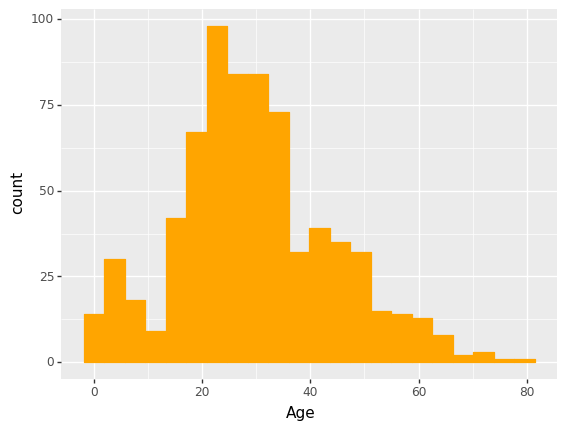


plot_mean_outcome_by_quantile


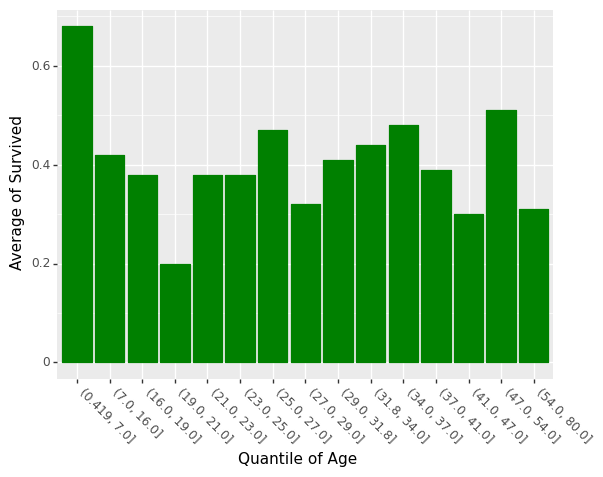


plot_outcome_counts


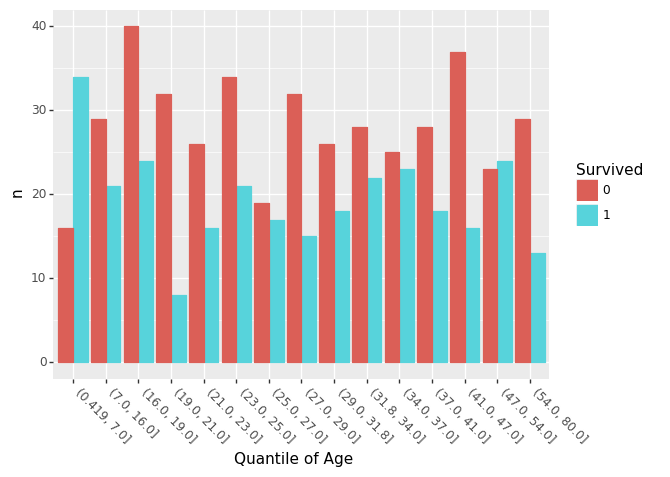

In [7]:
eda_age = summarise_continuous_feature(df_input = data, column = 'Age', outcome = 'Survived', n_quantiles = 15)

for (key, value) in eda_age.items():
    print(key)
    print(value)

mean_outcome_by_quantile
            quantile    n  avg_outcome
0     (-0.001, 7.55]   92         0.14
1      (7.55, 7.854]   87         0.30
2      (7.854, 8.05]  106         0.18
3       (8.05, 10.5]   78         0.23
4     (10.5, 14.454]   84         0.43
5   (14.454, 21.679]   88         0.42
6     (21.679, 27.0]   89         0.52
7     (27.0, 39.688]   91         0.37
8   (39.688, 77.958]   89         0.53
9  (77.958, 512.329]   87         0.76
outcome_count_by_quantile
             quantile Survived   n
0      (-0.001, 7.55]        0  79
1      (-0.001, 7.55]        1  13
2       (7.55, 7.854]        0  61
3       (7.55, 7.854]        1  26
4       (7.854, 8.05]        0  87
5       (7.854, 8.05]        1  19
6        (8.05, 10.5]        0  60
7        (8.05, 10.5]        1  18
8      (10.5, 14.454]        0  48
9      (10.5, 14.454]        1  36
10   (14.454, 21.679]        0  51
11   (14.454, 21.679]        1  37
12     (21.679, 27.0]        0  43
13     (21.679, 27.0]        1

/Users/sidbasu/opt/anaconda3/lib/python3.9/site-packages/plotnine/stats/stat_bin.py:95: PlotnineWarning: 'stat_bin()' using 'bins = 107'. Pick better value with 'binwidth'.


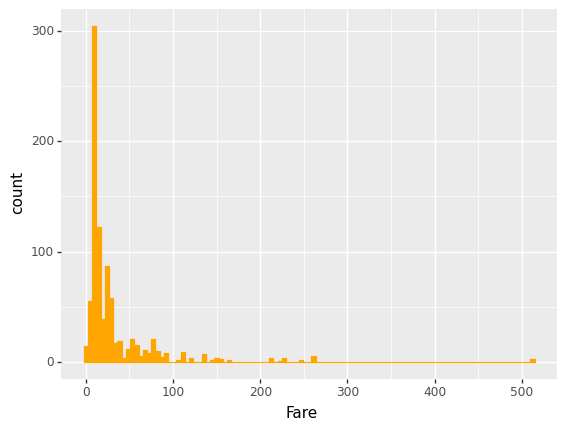


plot_mean_outcome_by_quantile


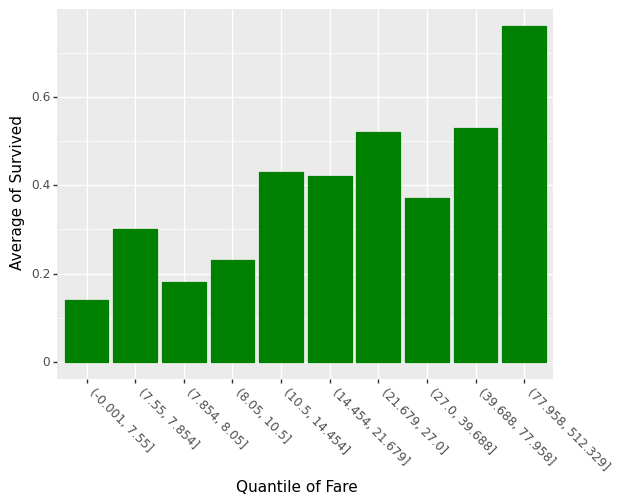


plot_outcome_counts


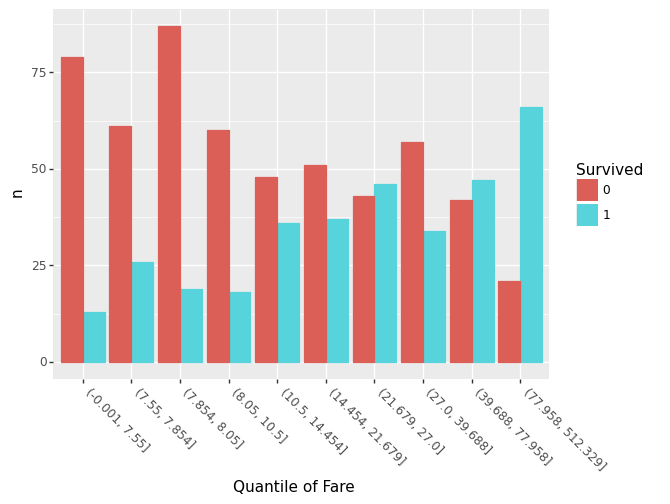

In [8]:
eda_fare = summarise_continuous_feature(df_input = data, column = 'Fare', outcome = 'Survived', n_quantiles = 10)

for (key, value) in eda_fare.items():
    print(key)
    print(value)

# Plot a histogram of every column because why not

/Users/sidbasu/opt/anaconda3/lib/python3.9/site-packages/plotnine/stats/stat_bin.py:95: PlotnineWarning: 'stat_bin()' using 'bins = 22'. Pick better value with 'binwidth'.
/Users/sidbasu/opt/anaconda3/lib/python3.9/site-packages/plotnine/layer.py:333: PlotnineWarning: stat_bin : Removed 177 rows containing non-finite values.


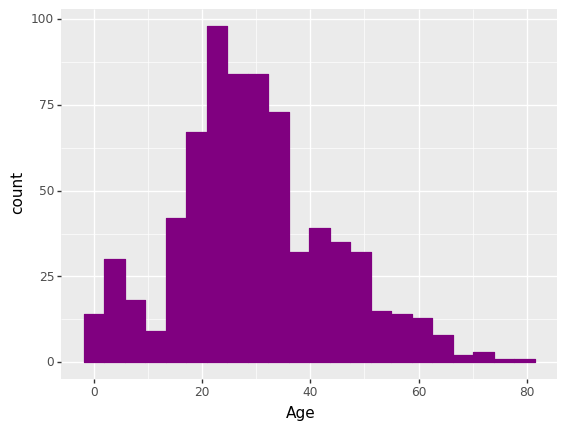

/Users/sidbasu/opt/anaconda3/lib/python3.9/site-packages/plotnine/stats/stat_bin.py:95: PlotnineWarning: 'stat_bin()' using 'bins = 39'. Pick better value with 'binwidth'.


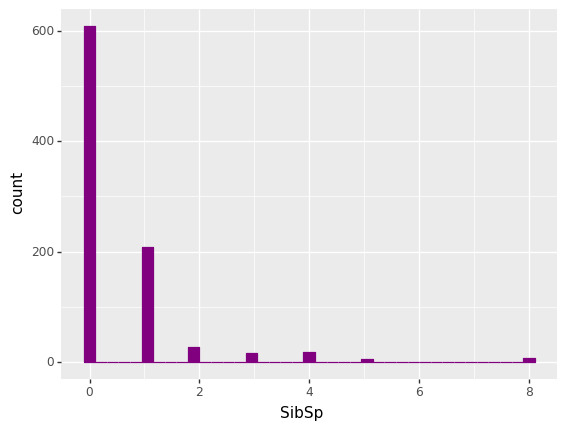

/Users/sidbasu/opt/anaconda3/lib/python3.9/site-packages/plotnine/stats/stat_bin.py:95: PlotnineWarning: 'stat_bin()' using 'bins = 30'. Pick better value with 'binwidth'.


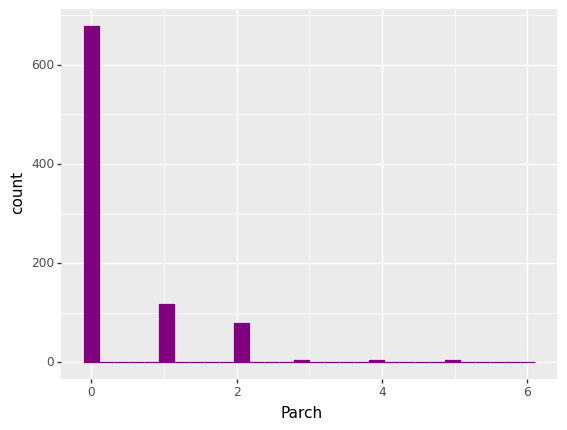

/Users/sidbasu/opt/anaconda3/lib/python3.9/site-packages/plotnine/stats/stat_bin.py:95: PlotnineWarning: 'stat_bin()' using 'bins = 107'. Pick better value with 'binwidth'.


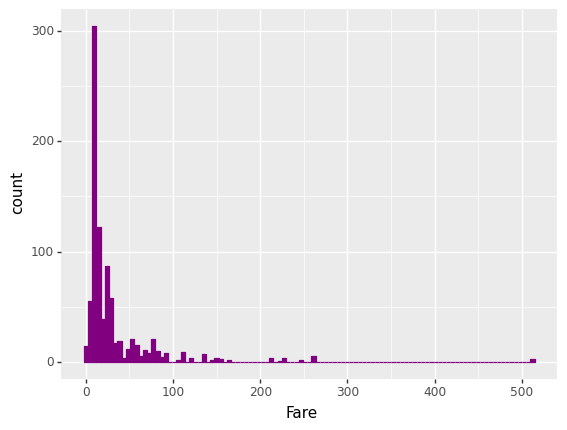

/Users/sidbasu/opt/anaconda3/lib/python3.9/site-packages/plotnine/stats/stat_bin.py:95: PlotnineWarning: 'stat_bin()' using 'bins = 10'. Pick better value with 'binwidth'.


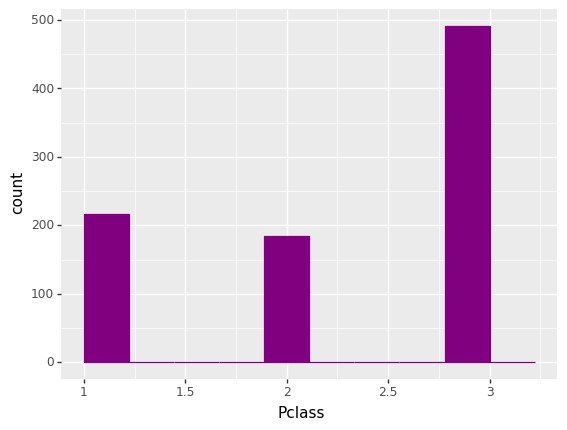

/Users/sidbasu/opt/anaconda3/lib/python3.9/site-packages/plotnine/stats/stat_bin.py:95: PlotnineWarning: 'stat_bin()' using 'bins = 5'. Pick better value with 'binwidth'.


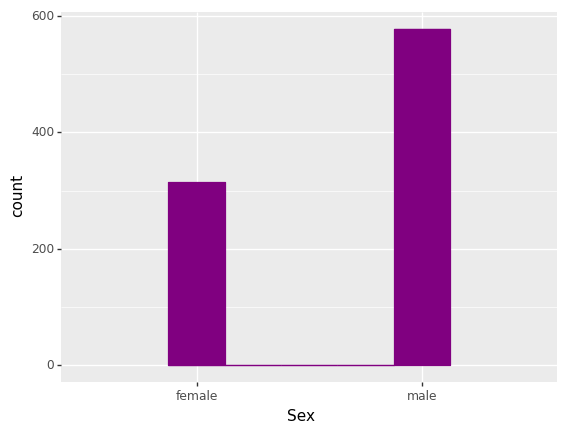

/Users/sidbasu/opt/anaconda3/lib/python3.9/site-packages/plotnine/stats/stat_bin.py:95: PlotnineWarning: 'stat_bin()' using 'bins = 15'. Pick better value with 'binwidth'.


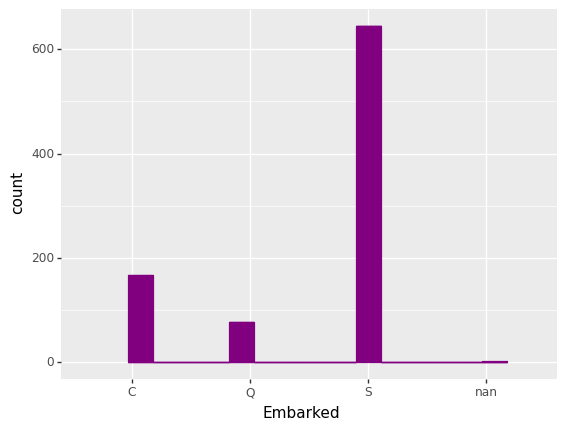

In [9]:
for column in numeric_cols + categorical_cols:
    x = (
        ggplot(data, aes(x = column)) + 
        geom_histogram(color = 'purple', fill = 'purple')
    )

    print(x)

# Look at patterns of `Nan`s and devise an imputation strategy

In [10]:
data.isna().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
quantile         0
dtype: int64

## Dealing with NA's in Age

In [11]:
data['Age_na'] = data['Age'].isna().astype(int)

#compute the fraction of people with missing age in each categorical column
for column in categorical_cols:
    print(data.groupby(column).agg(frac_missing = ('Age_na', 'mean')).reset_index().round(2))

   Pclass  frac_missing
0       1          0.14
1       2          0.06
2       3          0.28
      Sex  frac_missing
0  female          0.17
1    male          0.21
  Embarked  frac_missing
0        C          0.23
1        Q          0.64
2        S          0.14


In [12]:
#grouping by Age_na, see what categorical column distributions look like
for column in categorical_cols:
    print(data.groupby('Age_na')[column].value_counts(normalize=True))

Age_na  Pclass
0       3         0.497199
        1         0.260504
        2         0.242297
1       3         0.768362
        1         0.169492
        2         0.062147
Name: Pclass, dtype: float64
Age_na  Sex   
0       male      0.634454
        female    0.365546
1       male      0.700565
        female    0.299435
Name: Sex, dtype: float64
Age_na  Embarked
0       S           0.778090
        C           0.182584
        Q           0.039326
1       S           0.508475
        Q           0.276836
        C           0.214689
Name: Embarked, dtype: float64


In [13]:
# Filling the missing values in Age with the medians of Sex and Pclass groups

def impute_medians(df_input, target_col = 'Age', grouping_cols = ['Sex', 'Pclass']):

    group_medians = df_input.groupby(grouping_cols).agg(median = (target_col, 'median')).reset_index()
    df_return = df_input.merge(group_medians, on = grouping_cols)
    df_return.loc[df_return[target_col].isna(), target_col] = df_return['median']
    return(df_return)

#impute_medians(data, target_col='Age', grouping_cols=['Sex', 'Pclass'])


In [14]:
from sklearn.model_selection import train_test_split
X, y = data[numeric_cols + categorical_cols].copy(), np.asarray(data[target], dtype='int8')
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 20230116)

In [15]:
from sklearn.preprocessing import FunctionTransformer

transformer = FunctionTransformer(impute_medians)
transformer.fit_transform(X_train)[:10]

,Age,SibSp,Parch,Fare,Pclass,Sex,Embarked,median
0,26.0,1,0,7.8542,3,male,S,26.0
1,4.0,1,1,11.1333,3,male,S,26.0
2,47.0,0,0,9.0000,3,male,S,26.0
3,22.0,0,0,7.2250,3,male,C,26.0
4,19.0,0,0,7.6500,3,male,S,26.0
5,26.0,0,0,7.2500,3,male,S,26.0
6,45.0,0,0,8.0500,3,male,S,26.0
7,28.0,1,0,15.8500,3,male,S,26.0
8,19.0,0,0,8.0500,3,male,S,26.0
9,26.0,0,0,7.0500,3,male,S,26.0


In [16]:
transformer.transform(X_test)[:100]

,Age,SibSp,Parch,Fare,Pclass,Sex,Embarked,median
0,36.0,0,0,26.2875,1,male,S,37.5
1,47.0,0,0,52.0000,1,male,S,37.5
2,38.0,1,0,90.0000,1,male,S,37.5
3,31.0,1,0,52.0000,1,male,S,37.5
4,62.0,0,0,26.5500,1,male,S,37.5
...,...,...,...,...,...,...,...,...
95,18.0,0,0,7.7500,3,male,S,24.0
96,24.0,0,0,7.7500,3,male,Q,24.0
97,32.0,0,0,8.0500,3,male,S,24.0
98,24.0,0,0,7.7500,3,male,Q,24.0


In [17]:
from sklearn.impute import KNNImputer

#when given a single column, this imputer simply fills na's with the mean of the column
imputer = KNNImputer(n_neighbors = 3)
X, y = data[numeric_cols + categorical_cols].copy(), np.asarray(data[target], dtype='int8')
imputer.fit_transform(X[['Age']])[:10]


array([[22.        ],
       [38.        ],
       [26.        ],
       [35.        ],
       [35.        ],
       [29.69911765],
       [54.        ],
       [ 2.        ],
       [27.        ],
       [14.        ]])

In [18]:
from sklearn.experimental import enable_iterative_imputer  
from sklearn.impute import IterativeImputer

imputer = IterativeImputer(initial_strategy='median', skip_complete = True)
imputer.fit_transform(X[numeric_cols])

array([[22.        ,  1.        ,  0.        ,  7.25      ],
       [38.        ,  1.        ,  0.        , 71.2833    ],
       [26.        ,  0.        ,  0.        ,  7.925     ],
       ...,
       [24.17134966,  1.        ,  2.        , 23.45      ],
       [26.        ,  0.        ,  0.        , 30.        ],
       [32.        ,  0.        ,  0.        ,  7.75      ]])

# Does quantiling and imputing actually help model performance?

In [19]:
from sklearn.base import BaseEstimator, TransformerMixin

class FeatureSelector(BaseEstimator, TransformerMixin):
    def __init__(self, feature_names):
        self.feature_names = feature_names
    def fit(self, X, y = None):
        return self
    def transform(self, X, y = None):
        return X.loc[:, self.feature_names].copy(deep = True)

In [20]:
class DenseTransformer(TransformerMixin):
    def fit(self, X, y=None, **fit_params):
        return self
    def transform(self, X, y=None, **fit_params):
        return X.todense()

In [21]:
class TestImputer(BaseEstimator, TransformerMixin):
    def __init__(self, target_col, grouping_cols):
        self.target_col = target_col
        self.grouping_cols = grouping_cols

    def fit(self, X, y = None):
        self.group_medians = X.groupby(self.grouping_cols).agg(median = (self.target_col, 'median')).reset_index()
        print(self.group_medians)
        return self

    def transform(self, X, y = None):
        df_return = X.merge(self.group_medians, on = self.grouping_cols)
        #df_return.loc[df_return[self.target_col].isna(), self.target_col] = df_return['median']
        return df_return

In [22]:
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import StandardScaler, OneHotEncoder, KBinsDiscretizer
#from sklearn.impute import SimpleImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer, KNNImputer, SimpleImputer
import xgboost as xgb
from sklearn import set_config
set_config(display='diagram')

target = 'Survived'
numeric_cols = ['Age', 'SibSp', 'Parch', 'Fare']
categorical_cols = ['Pclass', 'Sex', 'Embarked']

X, y = data[numeric_cols + categorical_cols].copy(), np.asarray(data[target], dtype = 'int8')
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 20230118)

categorical_pipeline = Pipeline(steps = [
    ("selector", FeatureSelector(categorical_cols)),
    ("encoder", OneHotEncoder(handle_unknown='ignore')),
])

numerical_pipeline = Pipeline(steps = [
    ('selector', FeatureSelector(numeric_cols)),
    ('scaler', StandardScaler()),
])

feature_pipeline = FeatureUnion(
    transformer_list = [
    ("numerical_pipeline", numerical_pipeline),
    ("categorical_pipeline", categorical_pipeline),
    ]
)

xgb_model = xgb.XGBClassifier(use_label_encoder = False, eval_metric = 'logloss')

model_pipeline = Pipeline(
    steps = [
    ("feature_pipeline", feature_pipeline),
    ('to_dense', DenseTransformer()),
    ('imputer', IterativeImputer()),                               
    ("model", xgb_model)
    ]
)

model_pipeline.fit(X_train, y_train)

/Users/sidbasu/opt/anaconda3/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
/Users/sidbasu/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:593: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html


Pipeline(steps=[('feature_pipeline',
                 FeatureUnion(transformer_list=[('numerical_pipeline',
                                                 Pipeline(steps=[('selector',
                                                                  FeatureSelector(feature_names=['Age',
                                                                                                 'SibSp',
                                                                                                 'Parch',
                                                                                                 'Fare'])),
                                                                 ('scaler',
                                                                  StandardScaler())])),
                                                ('categorical_pipeline',
                                                 Pipeline(steps=[('selector',
                                                                  FeatureSelector(feature_names=['Pclass',
                                                                                                 'Sex',
                                                                                                 'Embarked'])),
                                                                 ('encoder',
                                                                  OneHotEncoder(ha...
                               importance_type=None, interaction_constraints='',
                               learning_rate=0.300000012, max_delta_step=0,
                               max_depth=6, min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estimators=100,
                               n_jobs=8, num_parallel_tree=1, predictor='auto',
                               random_state=0, reg_alpha=0, reg_lambda=1,
                               scale_pos_weight=1, subsample=1,
                               tree_method='exact', use_label_encoder=False,
                               validate_parameters=1, verbosity=None))])

In [23]:
preds = model_pipeline.predict_proba(X_test)[:,1]
preds_binary = model_pipeline.predict(X_test)

scores_list, cm, plots_list = model_diagnostics(y_test = y_test, preds = preds, preds_binary = preds_binary)

/Users/sidbasu/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:593: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
/Users/sidbasu/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:593: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html


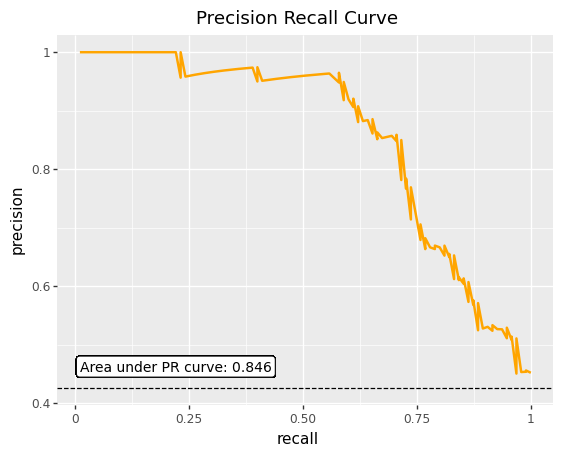

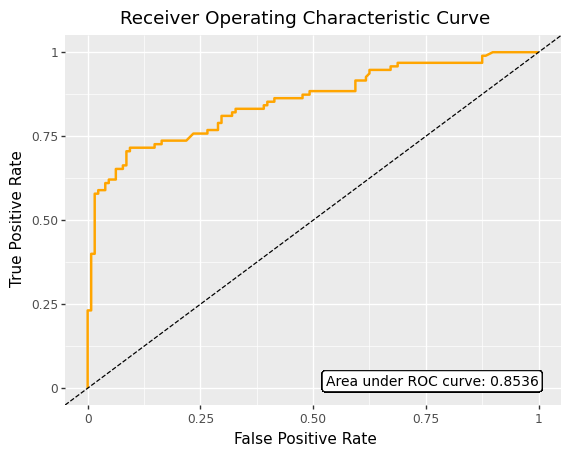

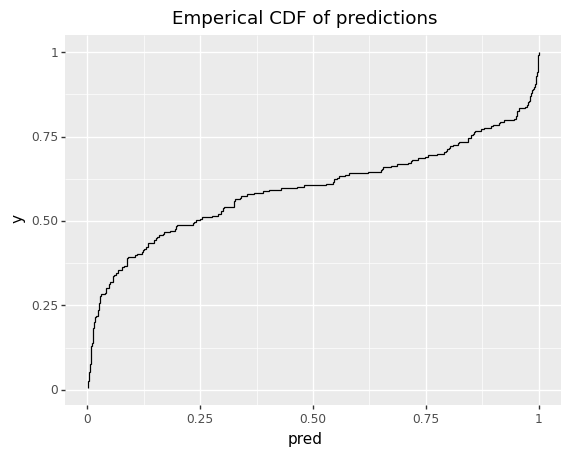

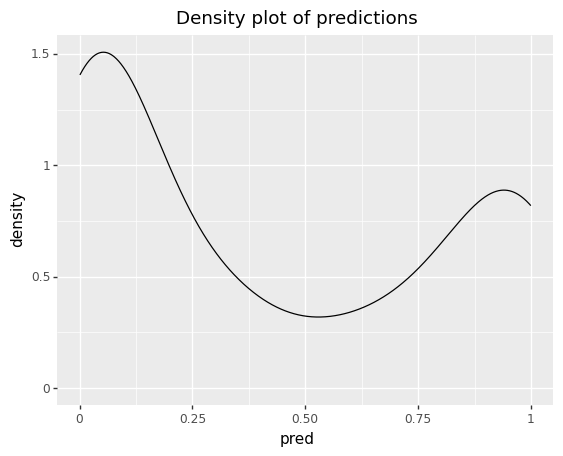

[<ggplot: (8760324221567)>,
 <ggplot: (8760324229364)>,
 <ggplot: (8760324230897)>,
 <ggplot: (8760324233738)>]

In [24]:
plots_list

# Do the same thing with ColumnTransformer

In [25]:
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, KBinsDiscretizer
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.experimental import enable_iterative_imputer  
from sklearn.impute import IterativeImputer
import xgboost as xgb

target = 'Survived'
numeric_cols = ['SibSp', 'Parch', 'Fare', 'Age']
categorical_cols = ['Pclass', 'Sex', 'Embarked']

X, y = data[numeric_cols + categorical_cols].copy(), np.asarray(data[target], dtype = 'int8')
skf = StratifiedKFold(n_splits=10, shuffle = True, random_state = 20230205)

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 20230118)


ct_encode = ColumnTransformer([
#    ('scaler', StandardScaler(), numeric_cols), #if just this line, the pipeline will only return the four numeric columns, scaled
    ('encoder', OneHotEncoder(handle_unknown='ignore'), categorical_cols), #this line adds dummies for class (3 values), sex (2 values) and embarked (4 values)
    ('pass_through_numerics', 'passthrough', numeric_cols)
])

ct_disc = ColumnTransformer(
    transformers = [('disc_age', KBinsDiscretizer(n_bins = 15, encode = 'ordinal'), [-1]),
                    ('disc_fare', KBinsDiscretizer(n_bins = 15, encode = 'ordinal'), [-2])],
    remainder = 'passthrough'
)

ct_scale = ColumnTransformer(
    transformers = [('scale', StandardScaler(), [-1, -2])],
    remainder = 'passthrough'
)

xgb_model = xgb.XGBClassifier(use_label_encoder = False, eval_metric = 'logloss')

pipe = Pipeline([
    ('encode_cats', ct_encode),
    ('imputer', IterativeImputer()),
    ('discretize', ct_scale),
    ('clf', xgb_model),
])

pipe.fit(X_train, y_train)

Pipeline(steps=[('encode_cats',
                 ColumnTransformer(transformers=[('encoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['Pclass', 'Sex',
                                                   'Embarked']),
                                                 ('pass_through_numerics',
                                                  'passthrough',
                                                  ['SibSp', 'Parch', 'Fare',
                                                   'Age'])])),
                ('imputer', IterativeImputer()),
                ('discretize',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('scale', StandardScaler(),
                                                  [-1, -2]...
                               importance_type=None, interaction_constraints='',
                               learning_rate=0.300000012, max_delta_step=0,
                               max_depth=6, min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estimators=100,
                               n_jobs=8, num_parallel_tree=1, predictor='auto',
                               random_state=0, reg_alpha=0, reg_lambda=1,
                               scale_pos_weight=1, subsample=1,
                               tree_method='exact', use_label_encoder=False,
                               validate_parameters=1, verbosity=None))])

In [26]:
cv_results = cross_validate(pipe, X, y, cv = skf, scoring = 'accuracy', return_estimator = True)
cv_estimators = cv_results['estimator']

In [27]:
preds_list = []
preds_binary_list = []
y_list = []

for i, (train_index, test_index) in enumerate(skf.split(X, y)):
    preds_list.append(cv_estimators[i].predict_proba(X.loc[test_index, :])[:,1])
    preds_binary_list.append(cv_estimators[i].predict(X.loc[test_index, :]))
    y_list.append(y[test_index])


In [28]:
from sklearn import metrics

#base scores (accuracy, average precision, f1 score)
dict_scores = {
    'accuracy': [],
    'average_precision': [],
    'f1_score': [],
    'auc': [],
    'fold': [],
}

for i, (y_test, preds, preds_binary) in enumerate(zip(y_list, preds_list, preds_binary_list)):
    dict_scores['accuracy'].append(metrics.accuracy_score(y_test, preds_binary))
    dict_scores['average_precision'].append(metrics.average_precision_score(y_true = y_test, y_score = preds))
    dict_scores['f1_score'].append(metrics.f1_score(y_test, preds_binary))
    dict_scores['auc'].append(metrics.roc_auc_score(y_test, preds))
    dict_scores['fold'].append(i)


df_scores = pd.DataFrame(dict_scores)
df_scores.drop('fold', axis = 1).mean()
#df_scores.var()

accuracy             0.811411
average_precision    0.838091
f1_score             0.747836
auc                  0.859075
dtype: float64

In [29]:
import matplotlib.pyplot as plt
# Confusion matrix
cm_list = []
for y_test, preds_binary in zip(y_list, preds_binary_list):
    cm_list.append(metrics.confusion_matrix(y_test, preds_binary))

print(1)
cm_array = np.stack(cm_list, axis = 0)
cm_mean = np.mean(cm_array, axis = 0)
cm_display = metrics.ConfusionMatrixDisplay(cm_mean)


1


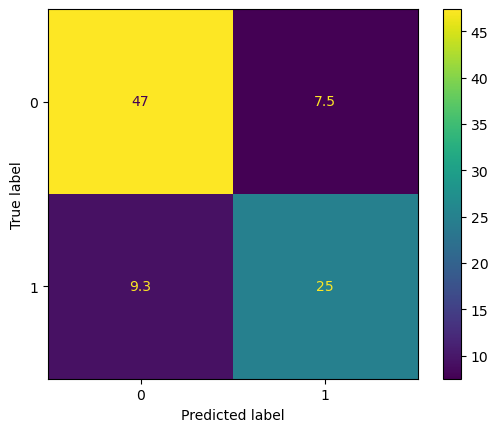

In [30]:
cm_display.plot()
plt.show();

In [31]:
from plotnine import ggplot, aes, geom_line, geom_bar, geom_density, geom_hline, ggtitle, xlab, ylab, geom_label, geom_abline

dict_pr_curve = {
    'precision': [],
    'recall': [],
    'threshold': [],
    'fold': [],
}

df_pr_curve = pd.DataFrame()

for i, (y_test, preds) in enumerate(zip(y_list, preds_list)):
    df_pr_curve_tmp = pd.DataFrame()
    x = metrics.precision_recall_curve(y_test, preds)

    df_pr_curve_tmp['precision'] = x[0][:-1]
    df_pr_curve_tmp['recall'] = x[1][:-1]
    df_pr_curve_tmp['threshold'] = x[2]
    df_pr_curve_tmp['fold'] = str(i)
    
    df_pr_curve = pd.concat([df_pr_curve, df_pr_curve_tmp])


df_pr_mean = (
    df_pr_curve
    .groupby('threshold')
    .agg(precision = ('precision', 'mean'),
         recall = ('recall', 'mean'))
    .reset_index()
#    .assign(fold = 'mean')
)

#df_pr_mean = df_pr_mean[['precision', 'recall', 'threshold', 'fold']]

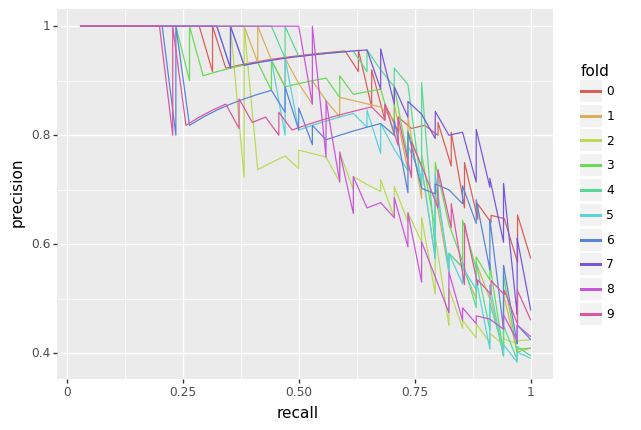

<ggplot: (8760375416932)>

In [32]:
(
    ggplot(df_pr_curve)
    + aes(x = 'recall', y = 'precision', color = 'fold')
    + geom_line()
)

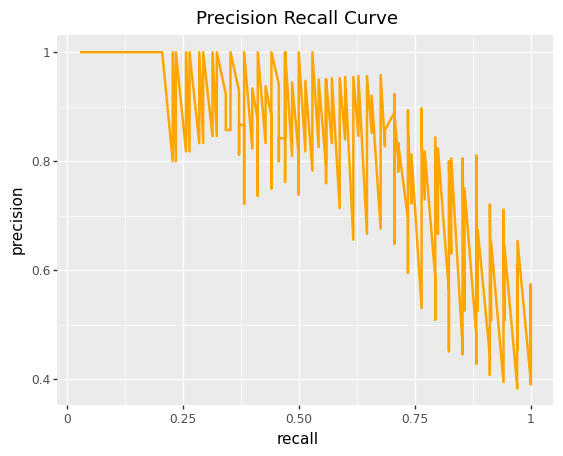

<ggplot: (8760412435962)>

In [34]:
# Precision recall curve
#auprc = metrics.auc(df_pr_mean['recall'], df_pr_mean['precision'])
auprc_noskill = np.mean(y_test)
#auprc_text = f"Area under PR curve: {round(auprc, 3)}"

pr_plot = (
    ggplot(df_pr_mean)
    + aes(x = 'recall', y = 'precision') 
    + geom_line(size = 1, color = 'orange')
#    + geom_hline(aes(yintercept = auprc_noskill), linetype = 'dashed')
    + ggtitle("Precision Recall Curve")
#    + geom_label(label = auprc_text, x = np.min(df_pr_mean['recall']), y = np.min(df_pr_mean['precision']), ha = 'left', va = 'bottom', size = 10)
)

pr_plot

In [35]:
dict_roc_curve = {
    'fpr': [],
    'tpr': [],
    'threshold': [],
    'fold': [],
}

df_roc_curve = pd.DataFrame()

for i, (y_test, preds) in enumerate(zip(y_list, preds_list)):
    df_roc_curve_tmp = pd.DataFrame()

    x = metrics.roc_curve(y_test, preds)

    df_roc_curve_tmp['fpr'] = x[0]
    df_roc_curve_tmp['tpr'] = x[1]
    df_roc_curve_tmp['threshold'] = x[2]
    df_roc_curve_tmp['fold'] = str(i)
    
    df_roc_curve = pd.concat([df_roc_curve, df_roc_curve_tmp])

df_roc_curve

,fpr,tpr,threshold,fold
0,0.000000,0.000000,1.999756,0
1,0.000000,0.028571,0.999756,0
2,0.000000,0.314286,0.990602,0
3,0.018182,0.314286,0.990475,0
4,0.018182,0.628571,0.876449,0
...,...,...,...,...
29,0.592593,0.971429,0.024820,9
30,0.703704,0.971429,0.012047,9
31,0.759259,0.971429,0.010963,9
32,0.759259,1.000000,0.010573,9


In [36]:
df_roc_mean = (
    df_roc_curve
    .groupby('threshold')
    .agg(fpr = ('fpr', 'mean'),
         tpr = ('tpr', 'mean'))
    .reset_index()
#    .assign(fold = 'mean')
)

df_roc_mean

,threshold,fpr,tpr
0,0.000348,1.0,1.0
1,0.000383,1.0,1.0
2,0.000420,1.0,1.0
3,0.000609,1.0,1.0
4,0.000864,1.0,1.0
...,...,...,...
305,1.999730,0.0,0.0
306,1.999756,0.0,0.0
307,1.999776,0.0,0.0
308,1.999836,0.0,0.0


In [37]:


# Receiver operating characteristic curve
x = metrics.roc_curve(y_test, preds)
df_roc_curve = pd.DataFrame()

df_roc_curve['fpr'] = x[0]
df_roc_curve['tpr'] = x[1]
df_roc_curve['threshold'] = x[2]

auroc = metrics.auc(df_roc_curve['fpr'], df_roc_curve['tpr'])
auroc_text = f"Area under ROC curve: {round(auroc, 4)}"

roc_plot = (
    ggplot(df_roc_curve, aes(x = 'fpr', y = 'tpr')) 
    + geom_line(size = 1, color = 'orange')
#    + geom_abline(intercept = 0, slope = 1, linetype = 'dashed')
    + xlab("False Positive Rate")
    + ylab("True Positive Rate")
    + ggtitle("Receiver Operating Characteristic Curve")
    + geom_label(label = auroc_text, x = np.max(df_roc_curve['fpr']), y = np.min(df_roc_curve['tpr']), ha = 'right', va = 'bottom', size = 10)
)

# Extra code

In [ ]:
preds = pipe.predict_proba(X_test)[:,1]
preds_binary = pipe.predict(X_test)

scores_list, cm, plots_list = model_diagnostics(y_test = y_test, preds = preds, preds_binary = preds_binary)